In [1]:
import wandb

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary
from PIL import Image
import random
import os
import shutil
from torchvision import datasets, transforms
import torch
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import torchvision.utils as vutils
from scipy.linalg import sqrtm
import numpy as np
import torchvision.models as models

In [3]:
folder_path = './image_data/ResizedImages/'  # Replace with your folder path

In [4]:
checkpoint_path = os.path.join(folder_path, '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)

In [5]:
# Check the dimensions of all images and identify those that are not 28x28
non_28x28_images = {}

for image_name in os.listdir(folder_path):
    if os.path.isdir(folder_path):
        continue
    with Image.open(os.path.join(folder_path, image_name)) as img:
        if img.size != (28, 28):
            non_28x28_images[image_name] = img.size

non_28x28_images

{}

In [6]:
# Transformations for your dataset
transform = transforms.Compose([
                                transforms.Grayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

# Assuming that all images are in 'ResizedImages/data/' directory
data_directory = "./image_data/"
trainset = datasets.ImageFolder(data_directory, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [7]:
data_iter = iter(trainloader)
images, labels = next(data_iter)
images.shape

torch.Size([128, 1, 28, 28])

In [9]:
device = torch.device('mps')

# Discriminator

In [10]:
def weights_init(m):
    # We need this function to initialize weights, with normal initialization, so the 
    # model trains properly
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
def disc_conv(in_c, out_c, ks=4, stride=2, padding=1, bn=True, out_layer=False):
    layers = [nn.Conv2d(in_c, out_c, kernel_size=ks, stride=stride, padding=padding, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.Sigmoid() if out_layer else nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

In [12]:
D = nn.Sequential(
    disc_conv(1, 32, bn=False),
    disc_conv(32, 64),
    disc_conv(64, 128, ks=3),
    disc_conv(128, 1, out_layer=True, bn=False, padding=0)
)
D
# our discriminator is a fully convolutional network, it decides wheter image is real or fake

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

# Generator

In [58]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(*[
                                      self.conv_block(100, 128, padding=0),
                                      self.conv_block(128, 64, stride=2, ks=3),
                                      self.conv_block(64, 32, stride=2),
                                      self.conv_block(32, 1, stride=2, bn=False, out_layer=True)
        ])
    # Our input is 100 dimensional random noise

    @staticmethod
    def conv_block(in_c, out_c, out_layer=False, ks=4, stride=1, padding=1, bias=False, bn=True):
        l = [nn.ConvTranspose2d(in_c, out_c, ks, stride=stride, padding=padding, bias=bias)]
        if bn: l.append(nn.BatchNorm2d(out_c))
        if out_layer: l.append(nn.Tanh())
        else: l.append(nn.ReLU(True))
        return nn.Sequential(*l)

    def forward(self, x):
        return self.layers(x)

In [59]:
G = Generator()
G

Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)

In [60]:
fixed_noise = torch.rand((64, 100, 1, 1))
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [61]:
criterion = nn.BCELoss()
criterion = criterion.to(device)

In [62]:
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [63]:
D = D.to(device)
G = G.to(device)


In [64]:
EPOCHS = 1000
FAKE_LABEL = 0.0 # 0.0
REAL_LABEL = 1.0 # 1.0

In [65]:
wandb.init(
    project='DCGAN_test_on_data',

    config = {
        "EPOCHS": 1000,
        "learning_rate": 0.0002,
        "FAKE_LABEL": 0.9,
        "REAL_LABEL": 1.2,
    }
)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


D_loss,▂▁▁▁▁▁▁▁▁▃▁▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▂▂▂▂▂
G_loss,▂▂▃▄▄▄▃▄▄█▃▃▃▂▁▄▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁
D_loss,1.10038
G_loss,0.9141


In [66]:
G_losses = []
D_losses = []
for epoch in range(1, EPOCHS + 1):
    loss_d = 0.0
    loss_g = 0.0

    for i, (images, labels) in enumerate(trainloader):
#         images = images.cuda()
        images = images.to(device)
#         fake_labels = torch.full((images.size(0), ), FAKE_LABEL).cuda()
        fake_labels = torch.full((images.size(0), ), FAKE_LABEL).to(device)
#         real_labels = torch.full((images.size(0), ), REAL_LABEL).cuda()
        real_labels = torch.full((images.size(0), ), REAL_LABEL).to(device)

        ## Train Discriminator ##
        D.zero_grad()

        d_real = D(images).view(-1)
        d_loss_real = criterion(d_real, real_labels)
        d_loss_real.backward()

#         noise = torch.randn((images.size(0), 100, 1, 1)).cuda()
#         noise = torch.randn((images.size(0), 100, 1, 1))
        noise = torch.randn((images.size(0), 100, 1, 1)).to(device)
        fake_images = G(noise)

        d_fake = D(fake_images.detach()).view(-1)
        d_loss_fake = criterion(d_fake, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optim_D.step()

        ## Train Generator ##
        G.zero_grad()

        d_fake = D(fake_images).view(-1)
        g_loss = criterion(d_fake, real_labels)
        g_loss.backward()
        # ... inside your training loop ...
        d_loss = d_loss_real + d_loss_fake
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
        wandb.log({"G_loss":g_loss, "D_loss": d_loss})


        optim_G.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")

Epoch [1/1000], Batch [0], LOSS_D: 1.5511507987976074, LOSS_G: 0.8947490453720093
Epoch [1/1000], Batch [10], LOSS_D: 0.634214460849762, LOSS_G: 1.857056736946106
Epoch [2/1000], Batch [0], LOSS_D: 0.6159813404083252, LOSS_G: 2.2325263023376465
Epoch [2/1000], Batch [10], LOSS_D: 0.34192249178886414, LOSS_G: 2.6874399185180664
Epoch [3/1000], Batch [0], LOSS_D: 0.33691346645355225, LOSS_G: 2.873856544494629
Epoch [3/1000], Batch [10], LOSS_D: 0.2509312033653259, LOSS_G: 3.141472816467285
Epoch [4/1000], Batch [0], LOSS_D: 0.24139384925365448, LOSS_G: 3.1066112518310547
Epoch [4/1000], Batch [10], LOSS_D: 0.23233042657375336, LOSS_G: 3.238356113433838
Epoch [5/1000], Batch [0], LOSS_D: 0.2389242947101593, LOSS_G: 3.4830899238586426
Epoch [5/1000], Batch [10], LOSS_D: 0.19873301684856415, LOSS_G: 3.1226859092712402
Epoch [6/1000], Batch [0], LOSS_D: 0.1526336371898651, LOSS_G: 3.3565921783447266
Epoch [6/1000], Batch [10], LOSS_D: 0.07112187147140503, LOSS_G: 3.984267473220825
Epoch [7/1

Epoch [50/1000], Batch [10], LOSS_D: 0.3226926922798157, LOSS_G: 2.044513702392578
Epoch [51/1000], Batch [0], LOSS_D: 0.2904924750328064, LOSS_G: 2.7647039890289307
Epoch [51/1000], Batch [10], LOSS_D: 6.191727161407471, LOSS_G: 4.6941070556640625
Epoch [52/1000], Batch [0], LOSS_D: 0.8336867094039917, LOSS_G: 1.0750728845596313
Epoch [52/1000], Batch [10], LOSS_D: 1.0008220672607422, LOSS_G: 1.2208818197250366
Epoch [53/1000], Batch [0], LOSS_D: 0.9139267206192017, LOSS_G: 1.2326067686080933
Epoch [53/1000], Batch [10], LOSS_D: 0.5317612290382385, LOSS_G: 1.6730902194976807
Epoch [54/1000], Batch [0], LOSS_D: 0.9980859160423279, LOSS_G: 2.281980037689209
Epoch [54/1000], Batch [10], LOSS_D: 0.47502291202545166, LOSS_G: 1.9224929809570312
Epoch [55/1000], Batch [0], LOSS_D: 0.8861272931098938, LOSS_G: 0.7971609234809875
Epoch [55/1000], Batch [10], LOSS_D: 0.7019747495651245, LOSS_G: 1.5791492462158203
Epoch [56/1000], Batch [0], LOSS_D: 1.190303087234497, LOSS_G: 0.7111949324607849
E

Epoch [100/1000], Batch [0], LOSS_D: 0.7613457441329956, LOSS_G: 1.5259836912155151
Epoch [100/1000], Batch [10], LOSS_D: 0.8293103575706482, LOSS_G: 1.4297657012939453
Epoch [101/1000], Batch [0], LOSS_D: 0.654593825340271, LOSS_G: 1.870073914527893
Epoch [101/1000], Batch [10], LOSS_D: 1.657564640045166, LOSS_G: 0.7978610992431641
Epoch [102/1000], Batch [0], LOSS_D: 0.7312262058258057, LOSS_G: 1.5442708730697632
Epoch [102/1000], Batch [10], LOSS_D: 0.9149598479270935, LOSS_G: 1.1073769330978394
Epoch [103/1000], Batch [0], LOSS_D: 1.0751957893371582, LOSS_G: 2.0762481689453125
Epoch [103/1000], Batch [10], LOSS_D: 0.7635208368301392, LOSS_G: 1.9074369668960571
Epoch [104/1000], Batch [0], LOSS_D: 1.140051245689392, LOSS_G: 2.5381202697753906
Epoch [104/1000], Batch [10], LOSS_D: 0.8484364748001099, LOSS_G: 1.3035905361175537
Epoch [105/1000], Batch [0], LOSS_D: 1.0612856149673462, LOSS_G: 1.5815975666046143
Epoch [105/1000], Batch [10], LOSS_D: 0.9167560338973999, LOSS_G: 0.8197016

Epoch [149/1000], Batch [0], LOSS_D: 0.9229994416236877, LOSS_G: 1.1041290760040283
Epoch [149/1000], Batch [10], LOSS_D: 0.8791888952255249, LOSS_G: 1.5013439655303955
Epoch [150/1000], Batch [0], LOSS_D: 0.8879202008247375, LOSS_G: 1.0676199197769165
Epoch [150/1000], Batch [10], LOSS_D: 0.5828218460083008, LOSS_G: 2.166268825531006
Epoch [151/1000], Batch [0], LOSS_D: 0.5723629593849182, LOSS_G: 1.559370994567871
Epoch [151/1000], Batch [10], LOSS_D: 0.534948468208313, LOSS_G: 1.7329140901565552
Epoch [152/1000], Batch [0], LOSS_D: 0.5539184808731079, LOSS_G: 2.0991721153259277
Epoch [152/1000], Batch [10], LOSS_D: 0.5100797414779663, LOSS_G: 1.1155428886413574
Epoch [153/1000], Batch [0], LOSS_D: 0.4987610876560211, LOSS_G: 1.8077161312103271
Epoch [153/1000], Batch [10], LOSS_D: 0.7718124985694885, LOSS_G: 2.4054691791534424
Epoch [154/1000], Batch [0], LOSS_D: 0.5671651363372803, LOSS_G: 2.3002147674560547
Epoch [154/1000], Batch [10], LOSS_D: 0.9747977256774902, LOSS_G: 1.442989

Epoch [198/1000], Batch [0], LOSS_D: 1.0414971113204956, LOSS_G: 0.8760899305343628
Epoch [198/1000], Batch [10], LOSS_D: 1.0566329956054688, LOSS_G: 3.760284423828125
Epoch [199/1000], Batch [0], LOSS_D: 0.7505757808685303, LOSS_G: 3.8829545974731445
Epoch [199/1000], Batch [10], LOSS_D: 0.5680475234985352, LOSS_G: 2.3004188537597656
Epoch [200/1000], Batch [0], LOSS_D: 0.3950269818305969, LOSS_G: 1.947880506515503
Epoch [200/1000], Batch [10], LOSS_D: 0.32255929708480835, LOSS_G: 2.051194190979004
Epoch [201/1000], Batch [0], LOSS_D: 0.45483243465423584, LOSS_G: 2.555197238922119
Epoch [201/1000], Batch [10], LOSS_D: 1.0692260265350342, LOSS_G: 0.9443905353546143
Epoch [202/1000], Batch [0], LOSS_D: 0.9993415474891663, LOSS_G: 1.177504301071167
Epoch [202/1000], Batch [10], LOSS_D: 0.7272213101387024, LOSS_G: 1.2928383350372314
Epoch [203/1000], Batch [0], LOSS_D: 0.5018672347068787, LOSS_G: 1.8013273477554321
Epoch [203/1000], Batch [10], LOSS_D: 0.39736253023147583, LOSS_G: 1.93516

Epoch [247/1000], Batch [0], LOSS_D: 1.476954460144043, LOSS_G: 0.8941622972488403
Epoch [247/1000], Batch [10], LOSS_D: 1.447927713394165, LOSS_G: 0.7464417219161987
Epoch [248/1000], Batch [0], LOSS_D: 1.2479040622711182, LOSS_G: 1.0356833934783936
Epoch [248/1000], Batch [10], LOSS_D: 1.1606104373931885, LOSS_G: 1.0308239459991455
Epoch [249/1000], Batch [0], LOSS_D: 1.1366310119628906, LOSS_G: 0.9925733208656311
Epoch [249/1000], Batch [10], LOSS_D: 1.0280864238739014, LOSS_G: 1.3554015159606934
Epoch [250/1000], Batch [0], LOSS_D: 0.8947271704673767, LOSS_G: 1.5321605205535889
Epoch [250/1000], Batch [10], LOSS_D: 0.9715331792831421, LOSS_G: 1.5899522304534912
Epoch [251/1000], Batch [0], LOSS_D: 0.64057457447052, LOSS_G: 2.040126323699951
Epoch [251/1000], Batch [10], LOSS_D: 0.5403798222541809, LOSS_G: 1.9292678833007812
Epoch [252/1000], Batch [0], LOSS_D: 0.41474151611328125, LOSS_G: 1.932106852531433
Epoch [252/1000], Batch [10], LOSS_D: 0.33679670095443726, LOSS_G: 2.1284189

Epoch [296/1000], Batch [0], LOSS_D: 0.5767430067062378, LOSS_G: 1.7216253280639648
Epoch [296/1000], Batch [10], LOSS_D: 0.38160964846611023, LOSS_G: 2.2830922603607178
Epoch [297/1000], Batch [0], LOSS_D: 0.30377447605133057, LOSS_G: 2.3778443336486816
Epoch [297/1000], Batch [10], LOSS_D: 0.31461000442504883, LOSS_G: 2.2105934619903564
Epoch [298/1000], Batch [0], LOSS_D: 0.2753887176513672, LOSS_G: 2.3467800617218018
Epoch [298/1000], Batch [10], LOSS_D: 0.26674914360046387, LOSS_G: 2.535560369491577
Epoch [299/1000], Batch [0], LOSS_D: 0.2702714204788208, LOSS_G: 2.7894649505615234
Epoch [299/1000], Batch [10], LOSS_D: 0.2790357172489166, LOSS_G: 2.4227771759033203
Epoch [300/1000], Batch [0], LOSS_D: 0.2649587094783783, LOSS_G: 2.7628071308135986
Epoch [300/1000], Batch [10], LOSS_D: 0.2676282525062561, LOSS_G: 2.4060158729553223
Epoch [301/1000], Batch [0], LOSS_D: 0.19702665507793427, LOSS_G: 2.7082254886627197
Epoch [301/1000], Batch [10], LOSS_D: 0.20352748036384583, LOSS_G: 

Epoch [344/1000], Batch [10], LOSS_D: 0.20744475722312927, LOSS_G: 2.618635416030884
Epoch [345/1000], Batch [0], LOSS_D: 0.2424446940422058, LOSS_G: 2.946631669998169
Epoch [345/1000], Batch [10], LOSS_D: 0.20785780251026154, LOSS_G: 3.1434645652770996
Epoch [346/1000], Batch [0], LOSS_D: 2.096242666244507, LOSS_G: 1.7969257831573486
Epoch [346/1000], Batch [10], LOSS_D: 0.8024901151657104, LOSS_G: 1.0086026191711426
Epoch [347/1000], Batch [0], LOSS_D: 0.8304728865623474, LOSS_G: 2.8019919395446777
Epoch [347/1000], Batch [10], LOSS_D: 0.3405120074748993, LOSS_G: 3.028074026107788
Epoch [348/1000], Batch [0], LOSS_D: 0.570868968963623, LOSS_G: 6.319994926452637
Epoch [348/1000], Batch [10], LOSS_D: 1.1698675155639648, LOSS_G: 1.1230077743530273
Epoch [349/1000], Batch [0], LOSS_D: 0.9267352819442749, LOSS_G: 1.3780990839004517
Epoch [349/1000], Batch [10], LOSS_D: 0.9780729413032532, LOSS_G: 1.0642924308776855
Epoch [350/1000], Batch [0], LOSS_D: 0.7644498944282532, LOSS_G: 1.5009438

Epoch [393/1000], Batch [10], LOSS_D: 0.4386647045612335, LOSS_G: 0.9812122583389282
Epoch [394/1000], Batch [0], LOSS_D: 0.9953131675720215, LOSS_G: 1.173234462738037
Epoch [394/1000], Batch [10], LOSS_D: 1.3967480659484863, LOSS_G: 0.996312141418457
Epoch [395/1000], Batch [0], LOSS_D: 0.911122739315033, LOSS_G: 1.4692614078521729
Epoch [395/1000], Batch [10], LOSS_D: 0.9691867828369141, LOSS_G: 1.3020191192626953
Epoch [396/1000], Batch [0], LOSS_D: 0.9535273313522339, LOSS_G: 1.4555505514144897
Epoch [396/1000], Batch [10], LOSS_D: 0.41267240047454834, LOSS_G: 2.0104923248291016
Epoch [397/1000], Batch [0], LOSS_D: 0.34071218967437744, LOSS_G: 2.1811141967773438
Epoch [397/1000], Batch [10], LOSS_D: 0.23820939660072327, LOSS_G: 2.5583364963531494
Epoch [398/1000], Batch [0], LOSS_D: 0.275168776512146, LOSS_G: 2.2755584716796875
Epoch [398/1000], Batch [10], LOSS_D: 0.26965898275375366, LOSS_G: 2.634582996368408
Epoch [399/1000], Batch [0], LOSS_D: 0.14459417760372162, LOSS_G: 2.985

Epoch [442/1000], Batch [10], LOSS_D: 0.18339335918426514, LOSS_G: 3.0769436359405518
Epoch [443/1000], Batch [0], LOSS_D: 0.17707102000713348, LOSS_G: 2.622274160385132
Epoch [443/1000], Batch [10], LOSS_D: 0.14579804241657257, LOSS_G: 3.375969409942627
Epoch [444/1000], Batch [0], LOSS_D: 0.14340369403362274, LOSS_G: 3.3342881202697754
Epoch [444/1000], Batch [10], LOSS_D: 0.18004904687404633, LOSS_G: 3.2199199199676514
Epoch [445/1000], Batch [0], LOSS_D: 0.1398160457611084, LOSS_G: 3.06668758392334
Epoch [445/1000], Batch [10], LOSS_D: 0.1436634659767151, LOSS_G: 3.5511205196380615
Epoch [446/1000], Batch [0], LOSS_D: 0.16736160218715668, LOSS_G: 3.033756732940674
Epoch [446/1000], Batch [10], LOSS_D: 0.19225355982780457, LOSS_G: 2.5386974811553955
Epoch [447/1000], Batch [0], LOSS_D: 0.2632361054420471, LOSS_G: 2.04941463470459
Epoch [447/1000], Batch [10], LOSS_D: 0.9432555437088013, LOSS_G: 1.1928365230560303
Epoch [448/1000], Batch [0], LOSS_D: 0.768384575843811, LOSS_G: 1.4722

Epoch [491/1000], Batch [0], LOSS_D: 0.1345326006412506, LOSS_G: 3.202777624130249
Epoch [491/1000], Batch [10], LOSS_D: 0.1453438401222229, LOSS_G: 3.1454086303710938
Epoch [492/1000], Batch [0], LOSS_D: 0.1663244366645813, LOSS_G: 3.1951041221618652
Epoch [492/1000], Batch [10], LOSS_D: 0.16767096519470215, LOSS_G: 3.5548624992370605
Epoch [493/1000], Batch [0], LOSS_D: 0.14966422319412231, LOSS_G: 3.334738254547119
Epoch [493/1000], Batch [10], LOSS_D: 0.11078988015651703, LOSS_G: 3.68721342086792
Epoch [494/1000], Batch [0], LOSS_D: 0.08245660364627838, LOSS_G: 3.5750350952148438
Epoch [494/1000], Batch [10], LOSS_D: 0.1764422506093979, LOSS_G: 3.6613776683807373
Epoch [495/1000], Batch [0], LOSS_D: 0.11088883876800537, LOSS_G: 3.55554461479187
Epoch [495/1000], Batch [10], LOSS_D: 2.274819850921631, LOSS_G: 6.021631717681885
Epoch [496/1000], Batch [0], LOSS_D: 0.6018964648246765, LOSS_G: 2.0601658821105957
Epoch [496/1000], Batch [10], LOSS_D: 0.5225493907928467, LOSS_G: 2.195978

Epoch [540/1000], Batch [0], LOSS_D: 0.1000828966498375, LOSS_G: 3.3486568927764893
Epoch [540/1000], Batch [10], LOSS_D: 0.13087008893489838, LOSS_G: 3.6011009216308594
Epoch [541/1000], Batch [0], LOSS_D: 0.07038767635822296, LOSS_G: 4.132859230041504
Epoch [541/1000], Batch [10], LOSS_D: 0.1098790317773819, LOSS_G: 3.570108413696289
Epoch [542/1000], Batch [0], LOSS_D: 0.08596936613321304, LOSS_G: 3.8745477199554443
Epoch [542/1000], Batch [10], LOSS_D: 0.12363580614328384, LOSS_G: 3.391911029815674
Epoch [543/1000], Batch [0], LOSS_D: 0.10051886737346649, LOSS_G: 3.5870118141174316
Epoch [543/1000], Batch [10], LOSS_D: 0.09455656260251999, LOSS_G: 3.6307010650634766
Epoch [544/1000], Batch [0], LOSS_D: 0.1154237613081932, LOSS_G: 4.058138847351074
Epoch [544/1000], Batch [10], LOSS_D: 0.08473016321659088, LOSS_G: 4.068039894104004
Epoch [545/1000], Batch [0], LOSS_D: 0.09437675774097443, LOSS_G: 3.613403797149658
Epoch [545/1000], Batch [10], LOSS_D: 0.1189485490322113, LOSS_G: 3.7

Epoch [588/1000], Batch [10], LOSS_D: 0.8401974439620972, LOSS_G: 1.630063772201538
Epoch [589/1000], Batch [0], LOSS_D: 0.6788418292999268, LOSS_G: 1.6602792739868164
Epoch [589/1000], Batch [10], LOSS_D: 0.5453797578811646, LOSS_G: 1.5106006860733032
Epoch [590/1000], Batch [0], LOSS_D: 0.5358964204788208, LOSS_G: 1.379287600517273
Epoch [590/1000], Batch [10], LOSS_D: 0.3417617976665497, LOSS_G: 3.404533624649048
Epoch [591/1000], Batch [0], LOSS_D: 0.7283778190612793, LOSS_G: 1.0803810358047485
Epoch [591/1000], Batch [10], LOSS_D: 0.4579817056655884, LOSS_G: 1.915283441543579
Epoch [592/1000], Batch [0], LOSS_D: 0.1952953338623047, LOSS_G: 4.0007758140563965
Epoch [592/1000], Batch [10], LOSS_D: 0.14440833032131195, LOSS_G: 3.3947877883911133
Epoch [593/1000], Batch [0], LOSS_D: 0.11729373037815094, LOSS_G: 3.4964723587036133
Epoch [593/1000], Batch [10], LOSS_D: 0.14550155401229858, LOSS_G: 3.2434463500976562
Epoch [594/1000], Batch [0], LOSS_D: 0.11133230477571487, LOSS_G: 3.838

Epoch [637/1000], Batch [0], LOSS_D: 0.6281405687332153, LOSS_G: 1.8221036195755005
Epoch [637/1000], Batch [10], LOSS_D: 0.5170555114746094, LOSS_G: 1.8056981563568115
Epoch [638/1000], Batch [0], LOSS_D: 0.5866662859916687, LOSS_G: 2.740434169769287
Epoch [638/1000], Batch [10], LOSS_D: 0.4825309216976166, LOSS_G: 1.9555144309997559
Epoch [639/1000], Batch [0], LOSS_D: 0.4239673912525177, LOSS_G: 2.4319534301757812
Epoch [639/1000], Batch [10], LOSS_D: 0.39192354679107666, LOSS_G: 2.3179972171783447
Epoch [640/1000], Batch [0], LOSS_D: 0.36618995666503906, LOSS_G: 2.763943910598755
Epoch [640/1000], Batch [10], LOSS_D: 0.2074170857667923, LOSS_G: 3.851257085800171
Epoch [641/1000], Batch [0], LOSS_D: 0.16856318712234497, LOSS_G: 4.107686996459961
Epoch [641/1000], Batch [10], LOSS_D: 1.5582952499389648, LOSS_G: 0.27556759119033813
Epoch [642/1000], Batch [0], LOSS_D: 0.5708450078964233, LOSS_G: 2.4847054481506348
Epoch [642/1000], Batch [10], LOSS_D: 0.25408482551574707, LOSS_G: 3.00

Epoch [685/1000], Batch [10], LOSS_D: 0.0867038294672966, LOSS_G: 4.037117004394531
Epoch [686/1000], Batch [0], LOSS_D: 0.09166249632835388, LOSS_G: 4.133305549621582
Epoch [686/1000], Batch [10], LOSS_D: 0.07914989441633224, LOSS_G: 4.137172222137451
Epoch [687/1000], Batch [0], LOSS_D: 0.05724663287401199, LOSS_G: 4.25882625579834
Epoch [687/1000], Batch [10], LOSS_D: 0.05894045904278755, LOSS_G: 4.486192226409912
Epoch [688/1000], Batch [0], LOSS_D: 0.07355688512325287, LOSS_G: 4.04767370223999
Epoch [688/1000], Batch [10], LOSS_D: 0.05875054746866226, LOSS_G: 4.643540382385254
Epoch [689/1000], Batch [0], LOSS_D: 0.06974078714847565, LOSS_G: 4.303988456726074
Epoch [689/1000], Batch [10], LOSS_D: 0.09055666625499725, LOSS_G: 3.720219135284424
Epoch [690/1000], Batch [0], LOSS_D: 0.06953704357147217, LOSS_G: 4.317849159240723
Epoch [690/1000], Batch [10], LOSS_D: 0.06760309636592865, LOSS_G: 4.274677753448486
Epoch [691/1000], Batch [0], LOSS_D: 0.06661373376846313, LOSS_G: 4.29464

Epoch [734/1000], Batch [0], LOSS_D: 0.1998359113931656, LOSS_G: 3.3726768493652344
Epoch [734/1000], Batch [10], LOSS_D: 0.13036790490150452, LOSS_G: 3.4304566383361816
Epoch [735/1000], Batch [0], LOSS_D: 0.3133538067340851, LOSS_G: 5.656065940856934
Epoch [735/1000], Batch [10], LOSS_D: 1.3030550479888916, LOSS_G: 2.2089955806732178
Epoch [736/1000], Batch [0], LOSS_D: 0.9187912940979004, LOSS_G: 1.5534203052520752
Epoch [736/1000], Batch [10], LOSS_D: 0.710374116897583, LOSS_G: 1.9463098049163818
Epoch [737/1000], Batch [0], LOSS_D: 1.0285884141921997, LOSS_G: 3.013998031616211
Epoch [737/1000], Batch [10], LOSS_D: 0.5216400623321533, LOSS_G: 1.9656643867492676
Epoch [738/1000], Batch [0], LOSS_D: 0.5635387897491455, LOSS_G: 2.659231424331665
Epoch [738/1000], Batch [10], LOSS_D: 0.3613351285457611, LOSS_G: 2.9407784938812256
Epoch [739/1000], Batch [0], LOSS_D: 0.5379603505134583, LOSS_G: 1.8457540273666382
Epoch [739/1000], Batch [10], LOSS_D: 2.739398717880249, LOSS_G: 0.3516089

Epoch [783/1000], Batch [0], LOSS_D: 0.5878820419311523, LOSS_G: 1.720353364944458
Epoch [783/1000], Batch [10], LOSS_D: 0.5124055743217468, LOSS_G: 2.062023162841797
Epoch [784/1000], Batch [0], LOSS_D: 0.3620467782020569, LOSS_G: 2.6283631324768066
Epoch [784/1000], Batch [10], LOSS_D: 0.29109591245651245, LOSS_G: 2.5002529621124268
Epoch [785/1000], Batch [0], LOSS_D: 0.30522388219833374, LOSS_G: 2.3564467430114746
Epoch [785/1000], Batch [10], LOSS_D: 0.2999456524848938, LOSS_G: 2.9707517623901367
Epoch [786/1000], Batch [0], LOSS_D: 0.1745542585849762, LOSS_G: 3.26035737991333
Epoch [786/1000], Batch [10], LOSS_D: 0.13387471437454224, LOSS_G: 3.899040937423706
Epoch [787/1000], Batch [0], LOSS_D: 0.11503122001886368, LOSS_G: 3.6244239807128906
Epoch [787/1000], Batch [10], LOSS_D: 0.0812063068151474, LOSS_G: 4.0224151611328125
Epoch [788/1000], Batch [0], LOSS_D: 0.10633872449398041, LOSS_G: 4.48293399810791
Epoch [788/1000], Batch [10], LOSS_D: 0.08367465436458588, LOSS_G: 4.7234

Epoch [831/1000], Batch [10], LOSS_D: 0.13323919475078583, LOSS_G: 3.8378453254699707
Epoch [832/1000], Batch [0], LOSS_D: 0.1380610466003418, LOSS_G: 3.514220714569092
Epoch [832/1000], Batch [10], LOSS_D: 0.12846282124519348, LOSS_G: 3.9911038875579834
Epoch [833/1000], Batch [0], LOSS_D: 0.08624802529811859, LOSS_G: 4.103501319885254
Epoch [833/1000], Batch [10], LOSS_D: 0.0786956250667572, LOSS_G: 4.360656261444092
Epoch [834/1000], Batch [0], LOSS_D: 0.07884465157985687, LOSS_G: 4.3071112632751465
Epoch [834/1000], Batch [10], LOSS_D: 0.08314023911952972, LOSS_G: 4.309127330780029
Epoch [835/1000], Batch [0], LOSS_D: 0.04805779457092285, LOSS_G: 4.933812141418457
Epoch [835/1000], Batch [10], LOSS_D: 0.04504290223121643, LOSS_G: 4.79400634765625
Epoch [836/1000], Batch [0], LOSS_D: 0.0612039789557457, LOSS_G: 4.676539897918701
Epoch [836/1000], Batch [10], LOSS_D: 0.04795539751648903, LOSS_G: 5.0394110679626465
Epoch [837/1000], Batch [0], LOSS_D: 0.05066101253032684, LOSS_G: 4.49

Epoch [880/1000], Batch [0], LOSS_D: 0.30496108531951904, LOSS_G: 2.5138819217681885
Epoch [880/1000], Batch [10], LOSS_D: 0.36157628893852234, LOSS_G: 3.4587087631225586
Epoch [881/1000], Batch [0], LOSS_D: 0.24474453926086426, LOSS_G: 2.692744731903076
Epoch [881/1000], Batch [10], LOSS_D: 0.159528911113739, LOSS_G: 3.8264856338500977
Epoch [882/1000], Batch [0], LOSS_D: 0.11851254105567932, LOSS_G: 4.272305965423584
Epoch [882/1000], Batch [10], LOSS_D: 0.07727297395467758, LOSS_G: 3.933213233947754
Epoch [883/1000], Batch [0], LOSS_D: 0.08236020058393478, LOSS_G: 4.382742404937744
Epoch [883/1000], Batch [10], LOSS_D: 0.051057443022727966, LOSS_G: 4.558837413787842
Epoch [884/1000], Batch [0], LOSS_D: 0.05875811725854874, LOSS_G: 4.343334197998047
Epoch [884/1000], Batch [10], LOSS_D: 0.06258989870548248, LOSS_G: 4.340939044952393
Epoch [885/1000], Batch [0], LOSS_D: 0.06330159306526184, LOSS_G: 4.759883403778076
Epoch [885/1000], Batch [10], LOSS_D: 0.05076145380735397, LOSS_G: 4.

Epoch [928/1000], Batch [10], LOSS_D: 0.18447594344615936, LOSS_G: 5.454198360443115
Epoch [929/1000], Batch [0], LOSS_D: 0.09899000823497772, LOSS_G: 4.084451198577881
Epoch [929/1000], Batch [10], LOSS_D: 0.07881029695272446, LOSS_G: 4.482156753540039
Epoch [930/1000], Batch [0], LOSS_D: 0.08432187139987946, LOSS_G: 4.589140892028809
Epoch [930/1000], Batch [10], LOSS_D: 0.07271964848041534, LOSS_G: 4.419677734375
Epoch [931/1000], Batch [0], LOSS_D: 0.05133018270134926, LOSS_G: 4.787315368652344
Epoch [931/1000], Batch [10], LOSS_D: 0.055622875690460205, LOSS_G: 4.2802629470825195
Epoch [932/1000], Batch [0], LOSS_D: 0.05606198310852051, LOSS_G: 5.109688758850098
Epoch [932/1000], Batch [10], LOSS_D: 0.04821134731173515, LOSS_G: 5.119316101074219
Epoch [933/1000], Batch [0], LOSS_D: 0.039935506880283356, LOSS_G: 4.924745559692383
Epoch [933/1000], Batch [10], LOSS_D: 0.04744187742471695, LOSS_G: 5.066273212432861
Epoch [934/1000], Batch [0], LOSS_D: 0.04395797848701477, LOSS_G: 5.03

Epoch [977/1000], Batch [0], LOSS_D: 0.03098006546497345, LOSS_G: 5.383017539978027
Epoch [977/1000], Batch [10], LOSS_D: 0.034828729927539825, LOSS_G: 5.395927429199219
Epoch [978/1000], Batch [0], LOSS_D: 0.03395126014947891, LOSS_G: 5.135833740234375
Epoch [978/1000], Batch [10], LOSS_D: 0.03217380493879318, LOSS_G: 4.864551544189453
Epoch [979/1000], Batch [0], LOSS_D: 0.040028929710388184, LOSS_G: 5.1258158683776855
Epoch [979/1000], Batch [10], LOSS_D: 0.039026279002428055, LOSS_G: 5.275073528289795
Epoch [980/1000], Batch [0], LOSS_D: 0.03023071214556694, LOSS_G: 5.380730152130127
Epoch [980/1000], Batch [10], LOSS_D: 0.02781524509191513, LOSS_G: 5.318831443786621
Epoch [981/1000], Batch [0], LOSS_D: 0.03240492194890976, LOSS_G: 5.356655120849609
Epoch [981/1000], Batch [10], LOSS_D: 0.0342264361679554, LOSS_G: 5.375387668609619
Epoch [982/1000], Batch [0], LOSS_D: 0.03236932307481766, LOSS_G: 5.193883419036865
Epoch [982/1000], Batch [10], LOSS_D: 0.025128379464149475, LOSS_G: 

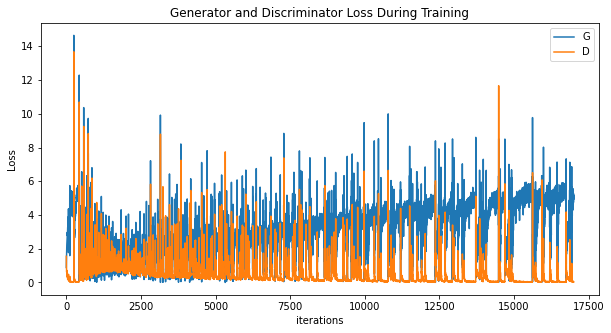

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
import pandas as pd

In [29]:
pd.DataFrame([G_losses, D_losses]).to_csv('G_D_losses_1.csv')

In [52]:
from torchsummary import summary

latent_vector_size = 100

G = G.to('cpu')

summary(G, input_size=(latent_vector_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 4, 4]         204,800
       BatchNorm2d-2            [-1, 128, 4, 4]             256
              ReLU-3            [-1, 128, 4, 4]               0
   ConvTranspose2d-4             [-1, 64, 7, 7]          73,728
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
   ConvTranspose2d-7           [-1, 32, 14, 14]          32,768
       BatchNorm2d-8           [-1, 32, 14, 14]              64
              ReLU-9           [-1, 32, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             512
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 312,256
Trainable params: 312,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [57]:
from torchsummary import summary

# latent_vector_size = 100

D = D.to('cpu')

summary(D, input_size=(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             512
         LeakyReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,768
       BatchNorm2d-4           [-1, 64, 16, 16]             128
         LeakyReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6            [-1, 128, 8, 8]          73,728
       BatchNorm2d-7            [-1, 128, 8, 8]             256
         LeakyReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9              [-1, 1, 3, 3]           2,048
          Sigmoid-10              [-1, 1, 3, 3]               0
Total params: 109,440
Trainable params: 109,440
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.06
Params size (MB): 0.42
Estimated T

In [31]:
G

Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)

In [75]:
inception_model = models.inception_v3(pretrained=True).cpu().eval()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
def get_features(images, model):
    images = images.cpu().float()  # Ensure images are on CPU in float format
    model = model.cpu().float()    # Ensure model is on CPU in float format

    # Resize images to match the Inception's input shape
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # Replicate the grayscale image across 3 channels
    images = images.repeat(1, 3, 1, 1)
    
    # Get features from the Inception model
    with torch.no_grad():
        features = model(images).detach().cpu().numpy()
    return features


In [79]:
# Assuming you have a dataloader named `dataloader`
data_iter = iter(trainloader)
real_images, _ = next(data_iter)

In [80]:
real_features = get_features(real_images, inception_model)
generated_features = get_features(generated_images, inception_model)


In [81]:
# Compute mean and covariance
mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

In [82]:
# Compute FID
ssdiff = np.sum((mu1 - mu2)**2.0)
covmean = sqrtm(sigma1.dot(sigma2))
if np.iscomplexobj(covmean):
    covmean = covmean.real
fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
print("FID score:", fid)

FID score: 717.678667755309
